# Given Catchment and Flowline delineate valley bottom

1. V-Bet Method
2. Slope Threshold
3. HAND Threshold
4. Geomorphons
5. Break Point Detection
6. Wavelet Curvature

In [50]:
import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np
import xrspatial
from shapely import Point
import matplotlib.pyplot as plt

In [151]:
def get_nearest_vertices(point, linestring):
    line_coords = linestring.coords
    distances = [point.distance(Point(x, y)) for x, y in line_coords]
    nearest_indices = np.argsort(distances)[:2]
    nearest_vertices = [Point(line_coords[int(i)]) for i in nearest_indices]
    return nearest_vertices

def sample_point_on_perpendicular_line(point, A, B, alpha):
    length = A.distance(B)
    x = point.x + alpha * (A.y - B.y) / length
    y = point.y + alpha * (B.x - A.x) / length
    return Point(x,y)

def get_cross_section(point, linestring, width, alpha_increment, raster):
    A,B = get_nearest_vertices(point, linestring)
    npoints = width // alpha_increment
    positive_alphas = [alpha_increment * n for n in range(npoints+1)]
    negative_alphas = [-i for i in positive_alphas]
    alphas = negative_alphas + positive_alphas
    sample_points = [sample_point_on_perpendicular_line(point, A, B, alpha) for alpha in alphas]
    values = [raster.sel(x=point.x, y=point.y, method='nearest').values for point in sample_points]
    return (alphas,values,sample_points)

In [56]:
dem = rioxarray.open_rasterio("../toy_data/11_dem.tif").squeeze()
hand = rioxarray.open_rasterio("../toy_data/11_hand.tif").squeeze()
flowline = gpd.read_file("../toy_data/11_streamline.shp")
stream_raster = rioxarray.open_rasterio("../toy_data/11_stream.tif").squeeze()

In [62]:
slope = xrspatial.slope(hand)

In [13]:
points = [flowline.interpolate(i/20, normalized=True) for i in range(21)]
points = pd.concat(points, ignore_index=True)
points = gpd.GeoSeries(points)
points.head()

0    POINT (-198247.926 -102782.473)
1    POINT (-198235.250 -102810.136)
2    POINT (-198211.257 -102827.432)
3    POINT (-198182.922 -102816.378)
4    POINT (-198154.120 -102812.446)
dtype: geometry

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

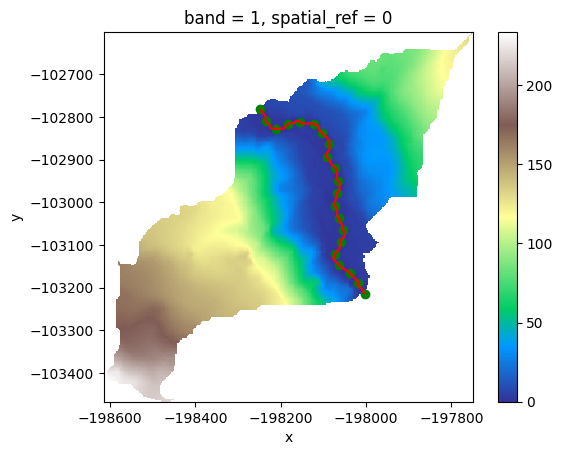

In [17]:
fig, ax = plt.subplots()
(hand.where(hand != -32768)).plot(ax=ax, cmap='terrain')
flowline.plot(ax=ax, color='red')
points.plot(ax=ax, color='green')

In [153]:
dfs = []
for i,point in enumerate(points):
    res = {}
    alphas, elevations, sample_points = get_cross_section(point, flowline['geometry'][0], 100, 4, hand)
    _, slopes, _ = get_cross_section(point, flowline['geometry'][0], 100, 4, slope)
    res['alpha'] = alphas
    res['elevation'] = elevations
    res['slope'] = slopes
    res['point'] = sample_points
    res['cross_section_index'] = i
    df = pd.DataFrame(res)
    dfs.append(df)
df = pd.concat(dfs)
df

,alpha,elevation,slope,point,cross_section_index
0,0,0.0,89.979034,POINT (-198247.92595611996 -102782.47306384971),0
1,-4,1.2992915563964864,89.98674,POINT (-198250.7543832447 -102785.30149097445),0
2,-8,2.099445288696291,89.99062,POINT (-198253.58281036944 -102788.1299180992),0
3,-12,-32768.0,89.99012,POINT (-198256.4112374942 -102790.95834522395),0
4,-16,2.344062492065433,89.98952,POINT (-198259.23966461894 -102793.7867723487),0
...,...,...,...,...,...
47,84,-32768.0,0.0,POINT (-198061.5474717032 -103273.47570885044),20
48,88,-32768.0,0.0,POINT (-198064.37589882794 -103276.30413597518),20
49,92,-32768.0,0.0,POINT (-198067.20432595268 -103279.13256309993),20
50,96,-32768.0,0.0,POINT (-198070.03275307745 -103281.96099022467),20


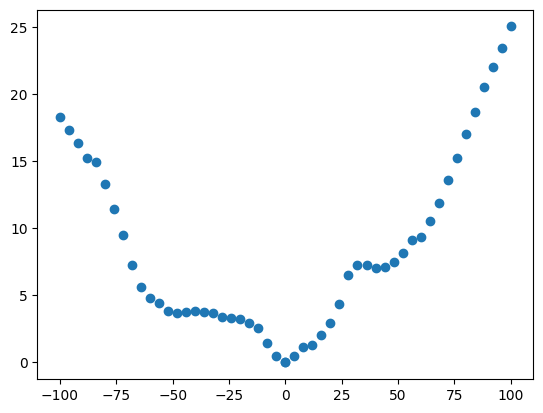

In [149]:
# find break point
def process_cross_section(cross_section_df):
    # split into left and right
    # remove null or -32768
    # get index where slope > 20 degrees
    # return inds
#fig, axes = plt.subplots(21,1)

for i in df['cross_section_index'].unique():
    elevation = df.loc[df['cross_section_index'] == i]
    elevation = elevation.loc[elevation['elevation'] > -1]



    #axes[i].plot(elevation['elevation'])
    if i == 8:
        neg_slope_break = np.argmax((elevation['slope'] > 20) & (elevation['alpha'] < 0))
        pos_slope_break = np.argmax((elevation['slope'] > 20) & (elevation['alpha'] > 0))
        plt.scatter(elevation['alpha'], elevation['elevation'])
        test = elevation

In [150]:
pos_slope_break, neg_slope_break

(31, 16)